Имплементация алгоритма Герцеля взята отсюда - https://gist.github.com/sebpiq/4128537

In [122]:
# Copyright © 2020 Sébastien Piquemal sebpiq@protonmail.com
# This work is free. You can redistribute it and/or modify it under the
# terms of the Do What The Fuck You Want To Public License, Version 2,
# as published by Sam Hocevar. See the license text below for more details.
#
# --------------------------------------------------------------------
#
#            DO WHAT THE FUCK YOU WANT TO PUBLIC LICENSE
#                    Version 2, December 2004
#
# Copyright (C) 2020 Sébastien Piquemal <sebpiq@protonmail.com>
#
# Everyone is permitted to copy and distribute verbatim or modified
# copies of this license document, and changing it is allowed as long
# as the name is changed.
#
#            DO WHAT THE FUCK YOU WANT TO PUBLIC LICENSE
#   TERMS AND CONDITIONS FOR COPYING, DISTRIBUTION AND MODIFICATION
#
#  0. You just DO WHAT THE FUCK YOU WANT TO.

import math

def goertzel(samples, sample_rate, *freqs):
    """
    Implementation of the Goertzel algorithm, useful for calculating individual
    terms of a discrete Fourier transform.

    `samples` is a windowed one-dimensional signal originally sampled at `sample_rate`.

    The function returns 2 arrays, one containing the actual frequencies calculated,
    the second the coefficients `(real part, imag part, power)` for each of those frequencies.
    For simple spectral analysis, the power is usually enough.

    Example of usage :

        freqs, results = goertzel(some_samples, 44100, (400, 500), (1000, 1100))
    """
    window_size = len(samples)
    f_step = sample_rate / float(window_size)
    f_step_normalized = 1.0 / window_size

    # Calculate all the DFT bins we have to compute to include frequencies
    # in `freqs`.
    bins = set()
    for f_range in freqs:
        f_start, f_end = f_range
        k_start = int(math.floor(f_start / f_step))
        k_end = int(math.ceil(f_end / f_step))

        if k_end > window_size - 1: raise ValueError('frequency out of range %s' % k_end)
        bins = bins.union(range(k_start, k_end))

    # For all the bins, calculate the DFT term
    n_range = range(0, window_size)
    freqs = []
    results = []
    for k in bins:

        # Bin frequency and coefficients for the computation
        f = k * f_step_normalized
        w_real = 2.0 * math.cos(2.0 * math.pi * f)
        w_imag = math.sin(2.0 * math.pi * f)

        # Doing the calculation on the whole sample
        d1, d2 = 0.0, 0.0
        for n in n_range:
            y  = samples[n] + w_real * d1 - d2
            d2, d1 = d1, y

        # Storing results `(real part, imag part, power)`
        results.append((
            0.5 * w_real * d1 - d2, w_imag * d1,
            d2**2 + d1**2 - w_real * d1 * d2)
        )
        freqs.append(f * sample_rate)
    return freqs, results

```Encoder``` - это несколько модифицированый код из дз 1.
Убраны лышние детали (интерфейс, звук), осталась только генерация чисел\семплов сигнала.
```Decoder``` - новая часть, реализует опредееление нажатой клавиши по семплам.

In [123]:
import matplotlib.pyplot as plt
import numpy as np


class Params:
    """Parameters common for both encoder and decoder. Used to keep it in one place."""
    def __init__(self) -> None:
        self.fs = 10_000
        self.duration = 0.5

class Encoder(Params):
    def __init__(self) -> None:
        super().__init__()
        self.freqs = {
            "1": (697, 1209),
            "2": (697, 1336),
            "3": (697, 1477),
            "4": (770, 1209),
            "5": (770, 1336),
            "6": (770, 1477),
            "7": (852, 1209),
            "8": (852, 1336),
            "9": (852, 1477),
            "0": (941, 1336),
            "a": (697, 1633),
            "b": (770, 1633),
            "c": (852, 1633),
            "d": (941, 1633),
            "*": (941, 1209),
            "#": (941, 1477),
        }

    def encode_tone(self, k: str) -> None:
        """Construct list of samples for single key press."""
        freqs = self.freqs[k]
        samples = np.mean(
            np.sin(np.outer(freqs, 2 * np.pi * np.arange(self.fs * self.duration) / self.fs)),
            axis=0).astype(np.float32)
        return samples

    def encode(self, sequence: str) -> list[list]:
        """Encode sequence of key presses. Return list of lists, inner lists are samples."""
        return [self.encode_tone(k) for k in sequence]

    def encode_with_noise(self, sequence: str, noise_scale: float = 0.3) -> list[list]:
        """Similar to encode, but with noise"""
        return [self.encode_tone(k) + np.random.normal(0, noise_scale, self.encode_tone(k).shape)
                for k in sequence]

class Decoder(Params):
    def __init__(self) -> None:
        super().__init__()
        self.freqs = {
            (697, 1209) : "1",
            (697, 1336) : "2",
            (697, 1477) : "3",
            (770, 1209) : "4",
            (770, 1336) : "5",
            (770, 1477) : "6",
            (852, 1209) : "7",
            (852, 1336) : "8",
            (852, 1477) : "9",
            (941, 1336) : "0",
            (697, 1633) : "a",
            (770, 1633) : "b",
            (852, 1633) : "c",
            (941, 1633) : "d",
            (941, 1209) : "*",
            (941, 1477) : "#",
        }

        WINDOW_WIDTH = 50
        self.low_freqs = [697, 770, 852, 941]
        self.low_freqs = {x:[x - WINDOW_WIDTH, x + WINDOW_WIDTH] for x in self.low_freqs}
        self.high_freqs = [1209, 1336, 1477, 1633]
        self.high_freqs = {x:[x - WINDOW_WIDTH, x + WINDOW_WIDTH] for x in self.high_freqs}

    def decode(self, samples: list[list]) -> list:
        """Decode pressed keys."""
        res = []
        for s in samples:
            low = []
            for freq in self.low_freqs:
                freq_interval = self.low_freqs[freq]
                _, results = goertzel(s, self.fs, freq_interval)
                r = np.array(results)[:, 2]
                low.append([np.max(r), freq])
            low_freq = max(low)[1]

            high = []
            for freq in self.high_freqs:
                freq_interval = self.high_freqs[freq]
                _, results = goertzel(s, self.fs, freq_interval)
                r = np.array(results)[:, 2]
                high.append([np.max(r), freq])
            high_freq = max(high)[1]

            res.append(self.freqs[(low_freq, high_freq)])
        return res

    def draw_spectrum(self, samples: list) -> None:
        "Plot spectrum for single signal"
        freqs, results = goertzel(samples, self.fs, (600, 1700))
        r = np.array(results)[:,2]

        fig, ax = plt.subplots(dpi=150)
        ax.set_xlabel("Frequency, Hz")
        ax.set_title(f"Spectrum")
        ax.plot(freqs, r)
        fig.show()


In [124]:
e = Encoder()
d = Decoder()

keys_pressed = "1801"
samples = e.encode(keys_pressed)
decoded = d.decode(samples)

print(*decoded, sep="")

1801


Оно работает, хотя и долго (это наверняка из-за "тупой" реализации с просто циклами и без оптимизаций).

C:\Users\Wicirelllis\AppData\Local\Temp\ipykernel_7664\2774508830.py:110: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


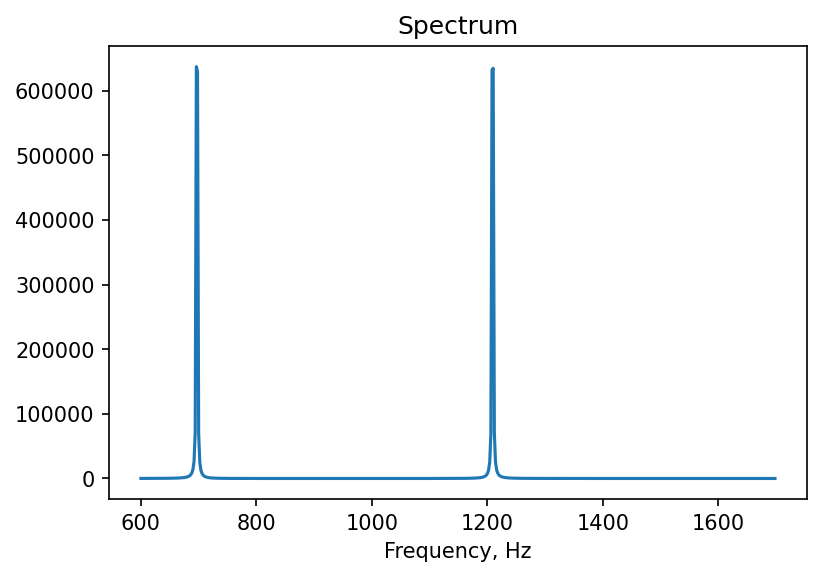

In [125]:
samples = e.encode("1")[0]
d.draw_spectrum(samples)

Спектр для клавиши ```1```. Частоты вполне похожи на те, что должны быть.

In [126]:
keys_pressed = "1801"
samples = e.encode_with_noise(keys_pressed)
decoded = d.decode(samples)

print(*decoded, sep="")

1801


(Не-)удивительным образом декодирование работает даже при добавлении шума.
Сделаем небольшую проверку, что мы генерировали сигналы верно.
Нарисуем сами сигналы с шумом и без.
Будет видно, что шум есть и вполне портит сигнал.

C:\Users\Wicirelllis\AppData\Local\Temp\ipykernel_7664\1411048324.py:9: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


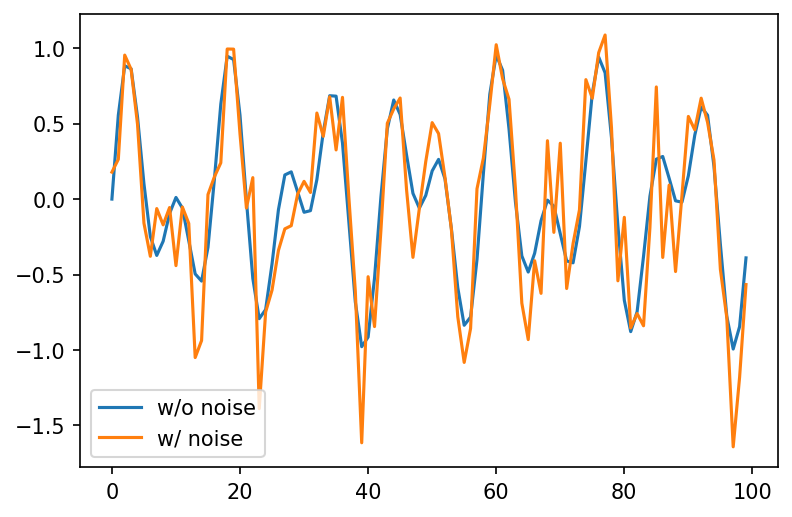

In [127]:
keys_pressed = "1"
samples = e.encode(keys_pressed)
samples_with_noise = e.encode_with_noise(keys_pressed)

fig, ax = plt.subplots(dpi=150)
ax.plot(np.array(samples[0][:100]), label="w/o noise")
ax.plot(np.array(samples_with_noise[0][:100]), label="w/ noise")
ax.legend()
fig.show()